# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

## 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

## 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [68]:
%pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [69]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# regex related
import re

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [70]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [71]:
# from google.colab import drive
# drive.mount('/content/drive')

In [72]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

# data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
# unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
# sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
# data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

# data = pd.read_csv("train.csv")
# unseen = pd.read_csv("test.csv")
# sample = pd.read_csv("sample.csv")
# data_dict = pd.read_csv("data_dictionary.csv")

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [73]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example:

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [74]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [75]:
data['churn_probability'].value_counts()

churn_probability
0    62867
1     7132
Name: count, dtype: int64

For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables.

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

## Common Utility Methods

In [76]:
# def summarize_missing_values(df):
#   """
#   Summarizes columns in a dataframe that has missing values.

#   Args:
#       df (pandas.DataFrame): The DataFrame to analyze.

#   Returns:
#       pandas.DataFrame: A DataFrame with columns 'Column Name', 'Missing Values', and 'percentMissing'.
#   """
#   # Filter for columns with null values
#   df_with_null = df.columns[df.isna().any()]
#   print(f"Following columns have null values: \n {df_with_null}\n")
#   # Add count of missing values for each column and percentage of nulls missing
#   # print only columns that have atleast a single missing columns
#   result_df = df[df_with_null].isna().agg(lambda x: x.sum(), axis=0) \
#               .rename_axis('Column Name') \
#               .reset_index(name='Missing Values') \
#               .assign(percentMissing=lambda x: (x['Missing Values'] / len(df)) * 100).round({'percentMissing': 2}) \
#               .sort_values(by='percentMissing', ascending=False)

#   result_df.reset_index(inplace=True, drop=False)
#   print(result_df)

In [77]:
def summarize_missing_values(df, x, y):
    """
    Summarizes columns in a dataframe that have missing values within a specified range.

    Args:
        df (pandas.DataFrame): The DataFrame to analyze.
        x (float): The minimum percentage of missing values.
        y (float): The maximum percentage of missing values.

    Returns:
        pandas.DataFrame: A DataFrame with columns 'Column Name', 'Missing Values', and 'percentMissing'.
    """
    # Calculate missing values and their percentages
    missing_values = df.isna().sum()
    percent_missing = (missing_values / len(df)) * 100

    # Filter columns based on missing value percentage range
    filtered_cols = (percent_missing > x) & (percent_missing <= y)
    result_df = pd.DataFrame({
        'Column Name': df.columns[filtered_cols],
        'Missing Values': missing_values[filtered_cols],
        'percentMissing': percent_missing[filtered_cols]
    }).round({'percentMissing': 2}).sort_values(by='percentMissing', ascending=False)

    result_df.reset_index(inplace=True, drop=True)

    # Print the result
    print(result_df)

    return result_df

In [78]:
def identify_same_value_features(df):
    """
    Identifies columns in a dataframe where all rows have the same value.

    Args:
        df (pandas.DataFrame): The DataFrame to analyze.

    Returns:
        list: A list of column names that have only one unique value.
    """
    sameValueColumns = []
    for col in df.columns:
        if df[col].nunique() == 1:
            sameValueColumns.append(col)
            print(df[col].value_counts())
    print(sameValueColumns)

    return sameValueColumns

In [79]:
def replace_blanks_with_zeros(df, column_names):
  """
  Replaces blank (NaN) values with zeros in a specified column if the column
  contains only binary values (0 and 1).

  Args:
      df (pd.DataFrame): The input DataFrame.
      column_name (str): The names of the columns to check and modify.

  Returns:
      None
  """
  for column_name in column_names:
    if df[column_name].dropna().isin([0, 1]).all():
      df[column_name].fillna(0, inplace=True)
      print(f"Found {column_name} and replacing blanks with zero")


In [80]:
def get_correlated_columns(df, threshold=0.60):
  """
  This function finds column pairs in a DataFrame with correlation greater than a threshold.

  Args:
      df: The pandas DataFrame to analyze.
      threshold: The minimum correlation coefficient (absolute value) to consider.

  Returns:
      A list of tuples containing the column names and their correlation coefficient.
  """
  correlation_matrix = df.corr()
  correlated_pairs = []

  # Iterate the upper triangle of the correlation matrix (excluding diagonal)
  for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
      # We should only process upper triangle and avoid self-correlation
      if col1 != col2 and col1 > col2:
        correlation_value = correlation_matrix.loc[col1, col2]
        # Check for absolute correlation greater than the threshold
        if abs(correlation_value) > threshold:
          correlated_pairs.append((col1, col2, correlation_value))

  return correlated_pairs

In [81]:
def print_correlated_column_pairs_with_corr_value(df, threshold=0.60):
  """
  This function uses get_correlated_columns() and finds and
  prints column pairs in a DataFrame with correlation greater than a threshold.

  Args:
      df: The pandas DataFrame to analyze.
      threshold: The minimum correlation coefficient (absolute value) to consider.

  Returns:
      A list of tuples containing the column names and their correlation coefficient.
  """
  numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
  numerical_cols.remove('churn_probability') #Removing target variable
  correlated_pairs = get_correlated_columns(df[numerical_cols], threshold)

  if correlated_pairs:
    print(f"Correlated column pairs (absolute correlation > {threshold}):")
    for pair in correlated_pairs:
      print(f"- {pair[0]} with {pair[1]}: {pair[2]:.2f}")
  else:
    print("No column pairs found with correlation greater than 0.60")

  return correlated_pairs

## Prepare Data


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [83]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


### Handle Date Fields

In [84]:
# Following are the date fields:
# TODO: Remove for now, to build model, revisit later to analyse
dateFields = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

data.drop(dateFields, axis=1, inplace=True)


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 163 entries, id to churn_probability
dtypes: float64(135), int64(28)
memory usage: 87.1 MB


## Handle Higly skewed or features with no variance

In [86]:
sameValueColumns = identify_same_value_features(data)

circle_id
109    69999
Name: count, dtype: int64
loc_og_t2o_mou
0.0    69297
Name: count, dtype: int64
std_og_t2o_mou
0.0    69297
Name: count, dtype: int64
loc_ic_t2o_mou
0.0    69297
Name: count, dtype: int64
std_og_t2c_mou_6
0.0    67231
Name: count, dtype: int64
std_og_t2c_mou_7
0.0    67312
Name: count, dtype: int64
std_og_t2c_mou_8
0.0    66296
Name: count, dtype: int64
std_ic_t2o_mou_6
0.0    67231
Name: count, dtype: int64
std_ic_t2o_mou_7
0.0    67312
Name: count, dtype: int64
std_ic_t2o_mou_8
0.0    66296
Name: count, dtype: int64
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


These features all have same values and therefore they can be removed since just having only one value constant in all rows doesn't help with analysis

In [87]:
sameValueColumns

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [88]:
data.drop(sameValueColumns, inplace=True, axis=1)

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 153 entries, id to churn_probability
dtypes: float64(126), int64(27)
memory usage: 81.7 MB


Let's also summarize the features using the df.describe method:

In [90]:
data.describe(include="all")

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,322.482226,324.089234,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,34.860000,32.240000,31.575000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,91.885000,91.800000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,232.990000,227.630000,229.345000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


### Analyse Missing values

In [91]:
result = summarize_missing_values(data, 0, 100)
result.shape

           Column Name  Missing Values  percentMissing
0            arpu_2g_6           52431           74.90
1    total_rech_data_6           52431           74.90
2            fb_user_6           52431           74.90
3            arpu_3g_6           52431           74.90
4      count_rech_3g_6           52431           74.90
..                 ...             ...             ...
103       std_og_mou_7            2687            3.84
104        og_others_7            2687            3.84
105       isd_og_mou_7            2687            3.84
106       isd_ic_mou_7            2687            3.84
107   std_ic_t2t_mou_7            2687            3.84

[108 rows x 3 columns]


(108, 3)

#### Replace missing values for columns that just have binary values

In [92]:
replace_blanks_with_zeros(data, result['Column Name'])

Found fb_user_6 and replacing blanks with zero
Found night_pck_user_6 and replacing blanks with zero
Found night_pck_user_7 and replacing blanks with zero
Found fb_user_7 and replacing blanks with zero
Found fb_user_8 and replacing blanks with zero
Found night_pck_user_8 and replacing blanks with zero


In [93]:
result = summarize_missing_values(data, 0, 100)
result.shape

            Column Name  Missing Values  percentMissing
0       count_rech_2g_6           52431           74.90
1     total_rech_data_6           52431           74.90
2             arpu_2g_6           52431           74.90
3    av_rech_amt_data_6           52431           74.90
4       max_rech_data_6           52431           74.90
..                  ...             ...             ...
97         std_og_mou_7            2687            3.84
98         isd_ic_mou_7            2687            3.84
99     std_og_t2f_mou_7            2687            3.84
100        loc_ic_mou_7            2687            3.84
101         ic_others_7            2687            3.84

[102 rows x 3 columns]


(102, 3)

In [94]:
# lets see how much are between 40 and 100
result = summarize_missing_values(data, 40, 100)
result.shape

           Column Name  Missing Values  percentMissing
0    total_rech_data_6           52431           74.90
1   av_rech_amt_data_6           52431           74.90
2      max_rech_data_6           52431           74.90
3            arpu_2g_6           52431           74.90
4      count_rech_2g_6           52431           74.90
5            arpu_3g_6           52431           74.90
6      count_rech_3g_6           52431           74.90
7            arpu_2g_7           52134           74.48
8            arpu_3g_7           52134           74.48
9   av_rech_amt_data_7           52134           74.48
10     count_rech_3g_7           52134           74.48
11   total_rech_data_7           52134           74.48
12     count_rech_2g_7           52134           74.48
13     max_rech_data_7           52134           74.48
14     count_rech_3g_8           51582           73.69
15     count_rech_2g_8           51582           73.69
16  av_rech_amt_data_8           51582           73.69
17     max

(21, 3)

In [95]:
lessThan40PercentColumns = [name for name, percent in zip(result['Column Name'], result['percentMissing']) if percent > 40 ]

print(lessThan40PercentColumns)

['total_rech_data_6', 'av_rech_amt_data_6', 'max_rech_data_6', 'arpu_2g_6', 'count_rech_2g_6', 'arpu_3g_6', 'count_rech_3g_6', 'arpu_2g_7', 'arpu_3g_7', 'av_rech_amt_data_7', 'count_rech_3g_7', 'total_rech_data_7', 'count_rech_2g_7', 'max_rech_data_7', 'count_rech_3g_8', 'count_rech_2g_8', 'av_rech_amt_data_8', 'max_rech_data_8', 'arpu_3g_8', 'total_rech_data_8', 'arpu_2g_8']


In [96]:
data.drop(columns=lessThan40PercentColumns, inplace=True, axis=1)

In [97]:
data.describe()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,...,0.081444,0.085487,0.229975,0.232132,0.234246,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,322.482226,324.089234,...,0.634547,0.680035,0.420819,0.422196,0.423530,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,91.885000,91.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,232.990000,227.630000,229.345000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


## EDA on Numerical Data

In [98]:
data['churn_probability'].value_counts()

churn_probability
0    62867
1     7132
Name: count, dtype: int64

In [99]:
numerical_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
print(numerical_cols)

['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8

In [100]:
numerical_cols.remove('churn_probability') #Removing target variable
correlationMatrix = data[numerical_cols].corr()

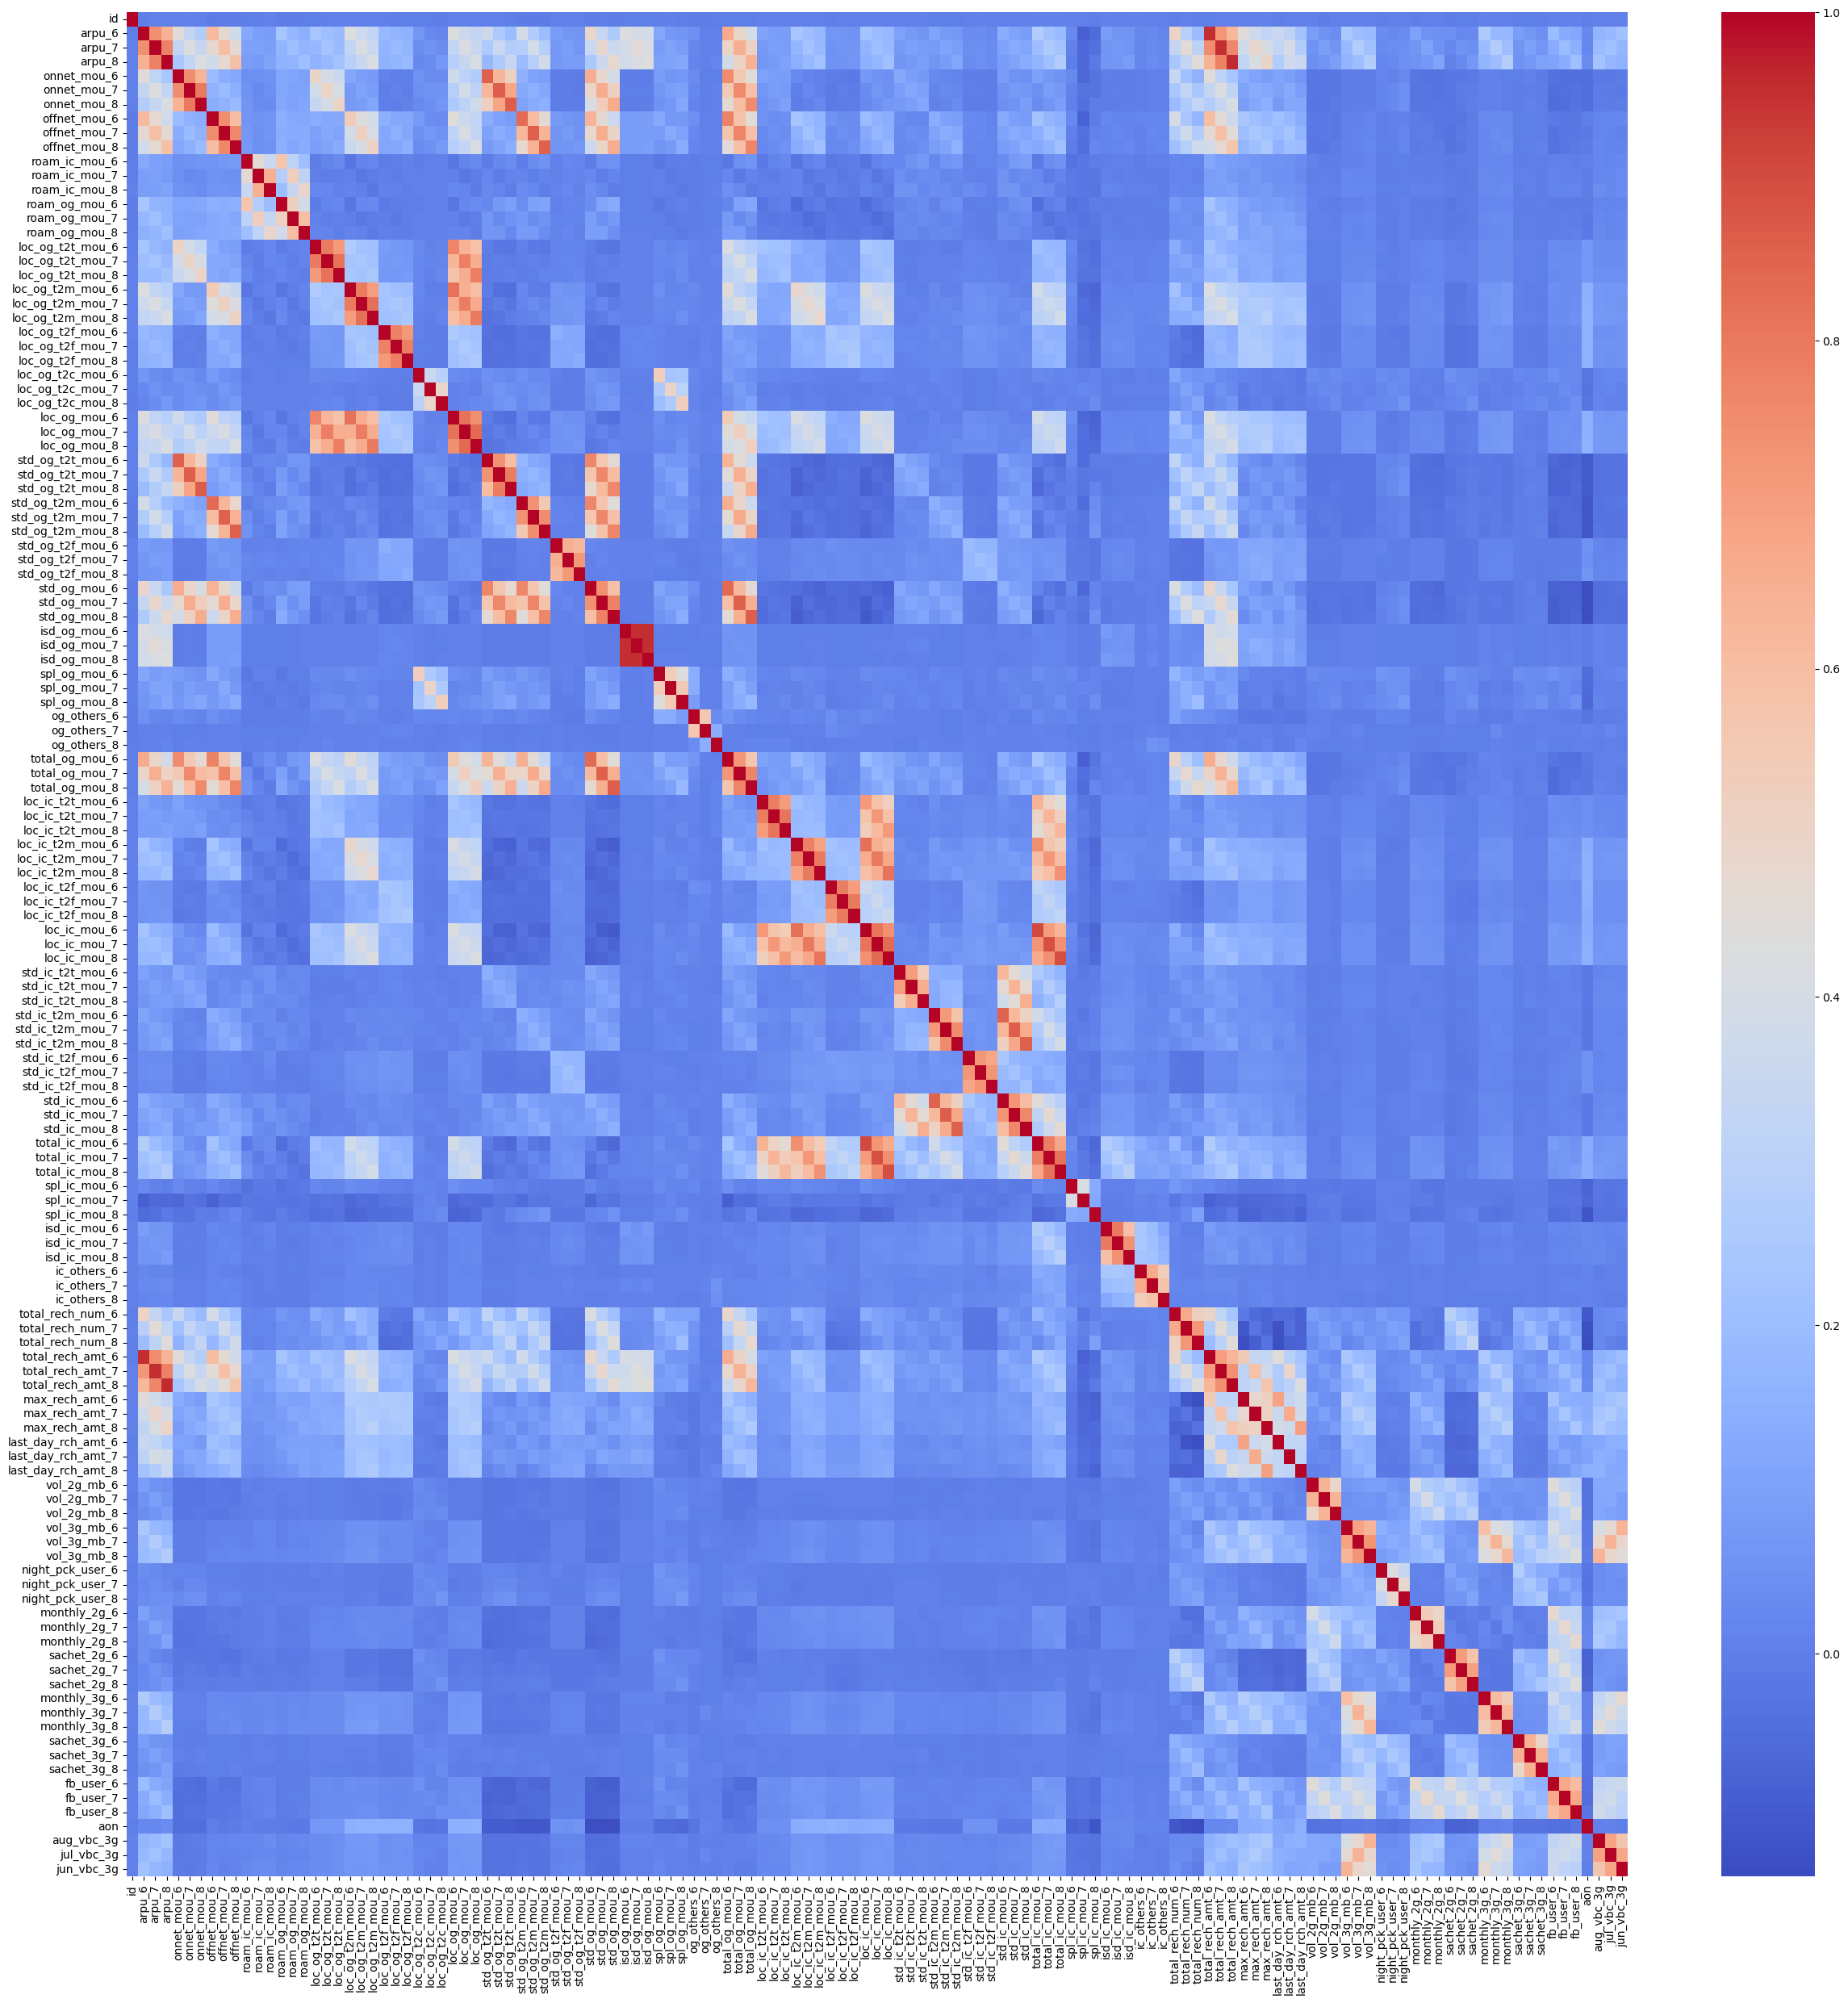

In [101]:
#print(correlationMatrix)
plt.figure(figsize=(30, 30))
hm = sns.heatmap(correlationMatrix, cmap='coolwarm')
plt.show()

We could observe multi-collinearity between feature variables. This will lead to High Variance in the estimated coefficients. So we need to remove one of them in each collinearity pair.

In [102]:
# Get all column pairs that have high correlation between them
print_correlated_column_pairs_with_corr_value(data, threshold=0.7)

Correlated column pairs (absolute correlation > 0.7):
- arpu_7 with arpu_6: 0.74
- arpu_8 with arpu_7: 0.78
- onnet_mou_7 with onnet_mou_6: 0.75
- onnet_mou_8 with onnet_mou_7: 0.79
- offnet_mou_7 with offnet_mou_6: 0.75
- offnet_mou_8 with offnet_mou_7: 0.76
- loc_og_t2t_mou_6 with loc_og_mou_6: 0.77
- loc_og_t2t_mou_7 with loc_og_t2t_mou_6: 0.79
- loc_og_t2t_mou_7 with loc_og_mou_7: 0.78
- loc_og_t2t_mou_8 with loc_og_t2t_mou_6: 0.71
- loc_og_t2t_mou_8 with loc_og_t2t_mou_7: 0.82
- loc_og_t2t_mou_8 with loc_og_mou_8: 0.79
- loc_og_t2m_mou_6 with loc_og_mou_6: 0.81
- loc_og_t2m_mou_7 with loc_og_t2m_mou_6: 0.79
- loc_og_t2m_mou_7 with loc_og_mou_7: 0.79
- loc_og_t2m_mou_8 with loc_og_t2m_mou_6: 0.71
- loc_og_t2m_mou_8 with loc_og_t2m_mou_7: 0.82
- loc_og_t2m_mou_8 with loc_og_mou_8: 0.79
- loc_og_t2f_mou_7 with loc_og_t2f_mou_6: 0.78
- loc_og_t2f_mou_8 with loc_og_t2f_mou_6: 0.72
- loc_og_t2f_mou_8 with loc_og_t2f_mou_7: 0.78
- loc_og_mou_7 with loc_og_mou_6: 0.82
- loc_og_mou_8 with 

[('arpu_7', 'arpu_6', 0.7437299211672721),
 ('arpu_8', 'arpu_7', 0.7823318999053633),
 ('onnet_mou_7', 'onnet_mou_6', 0.7489472135509461),
 ('onnet_mou_8', 'onnet_mou_7', 0.7947259035730629),
 ('offnet_mou_7', 'offnet_mou_6', 0.7505458924133811),
 ('offnet_mou_8', 'offnet_mou_7', 0.7632500876016914),
 ('loc_og_t2t_mou_6', 'loc_og_mou_6', 0.7733955480158915),
 ('loc_og_t2t_mou_7', 'loc_og_t2t_mou_6', 0.7936445195042349),
 ('loc_og_t2t_mou_7', 'loc_og_mou_7', 0.783470580765618),
 ('loc_og_t2t_mou_8', 'loc_og_t2t_mou_6', 0.7120251490100968),
 ('loc_og_t2t_mou_8', 'loc_og_t2t_mou_7', 0.8175408736170799),
 ('loc_og_t2t_mou_8', 'loc_og_mou_8', 0.7857264176439137),
 ('loc_og_t2m_mou_6', 'loc_og_mou_6', 0.8138280648979287),
 ('loc_og_t2m_mou_7', 'loc_og_t2m_mou_6', 0.7948136152679364),
 ('loc_og_t2m_mou_7', 'loc_og_mou_7', 0.7900837652095054),
 ('loc_og_t2m_mou_8', 'loc_og_t2m_mou_6', 0.7066894094266206),
 ('loc_og_t2m_mou_8', 'loc_og_t2m_mou_7', 0.8186611169401858),
 ('loc_og_t2m_mou_8', 'loc

Following general observations are noted from the above list of multi-collinear pairs
1. The columns related to the 7th month have high collinearity with both 6 and 8. Lets analyse and remove 7th month columns.

In [103]:
pattern = re.compile(r'.*7$')
columns_ending_7 = [col for col in data.columns if pattern.match(col)]

In [104]:
print(columns_ending_7)

['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7', 'total_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7', 'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7', 'last_day_rch_amt_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'night_pck_user_7', 'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_7', 'sachet_3g_7', 'fb_user_7']


In [105]:
columns_ending_7 = ['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'total_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'isd_ic_mou_7', 'total_rech_num_7', 'total_rech_amt_7', 'vol_3g_mb_7', 'sachet_2g_7']
data.drop(columns=columns_ending_7, inplace=True)

In [106]:
data.shape

(69999, 105)

In [107]:
# lets again analyse for columns more than 70%
# Get all column pairs that have high correlation between them
print_correlated_column_pairs_with_corr_value(data, threshold=0.9)

Correlated column pairs (absolute correlation > 0.9):
- isd_og_mou_8 with isd_og_mou_6: 0.95
- total_ic_mou_6 with loc_ic_mou_6: 0.90
- total_rech_amt_6 with arpu_6: 0.95
- total_rech_amt_8 with arpu_8: 0.96


[('isd_og_mou_8', 'isd_og_mou_6', 0.9540547101788628),
 ('total_ic_mou_6', 'loc_ic_mou_6', 0.9027216036022583),
 ('total_rech_amt_6', 'arpu_6', 0.9527756673973884),
 ('total_rech_amt_8', 'arpu_8', 0.958333127720694)]

In [108]:
high_correlation_cols = ['isd_og_mou_6', 'loc_ic_mou_6', 'arpu_6', 'arpu_8', 'loc_ic_mou_8', 'onnet_mou_6', 'std_og_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_6', 'loc_og_mou_6', 'std_og_t2m_mou_8', 'offnet_mou_6', 'std_og_mou_6', 'std_og_mou_8']
data.drop(columns=high_correlation_cols, inplace=True)

In [109]:
print_correlated_column_pairs_with_corr_value(data, threshold=0.8)

No column pairs found with correlation greater than 0.60


[]

In [110]:
data.shape

(69999, 91)

In [111]:
data.head(3)

,id,onnet_mou_8,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,1.29,2.33,0.0,0.0,0.0,0.0,0.0,0.0,2.23,...,0,0,0.0,0.0,0.0,1958,0.0,0.0,0.0,0
1,1,0.00,30.89,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0,0,0.0,1.0,0.0,710,0.0,0.0,0.0,0
2,2,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.53,...,0,0,0.0,0.0,0.0,882,0.0,0.0,0.0,0


# Splitting train and test data to avoid any contamination of the test data

In [112]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 90), (69999,))

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 90), (14000, 90), (55999,), (14000,))

In [114]:
X_train.head()

,id,onnet_mou_8,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
23179,23179,16.56,97.76,0.0,0.0,0.0,0.0,0.0,0.0,5.88,...,0,0,0,0.0,0.0,0.0,2372,0.0,0.0,0.00
52403,52403,242.13,380.21,0.0,0.0,0.0,0.0,0.0,0.0,367.64,...,0,0,0,0.0,0.0,0.0,2844,0.0,0.0,0.00
5819,5819,0.00,200.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0,0,0,0.0,0.0,0.0,2491,0.0,0.0,0.00
62854,62854,29.49,205.78,0.0,0.0,0.0,0.0,0.0,0.0,5.99,...,0,0,0,0.0,0.0,0.0,521,0.0,0.0,0.00
1347,1347,6.69,25.89,0.0,0.0,0.0,0.0,0.0,0.0,2.24,...,0,0,0,0.0,0.0,0.0,1008,0.0,0.0,98.55


In [115]:
y_train.head()

23179    0
52403    0
5819     0
62854    0
1347     0
Name: churn_probability, dtype: int64

In [116]:
y_train.value_counts()

churn_probability
0    50320
1     5679
Name: count, dtype: int64

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

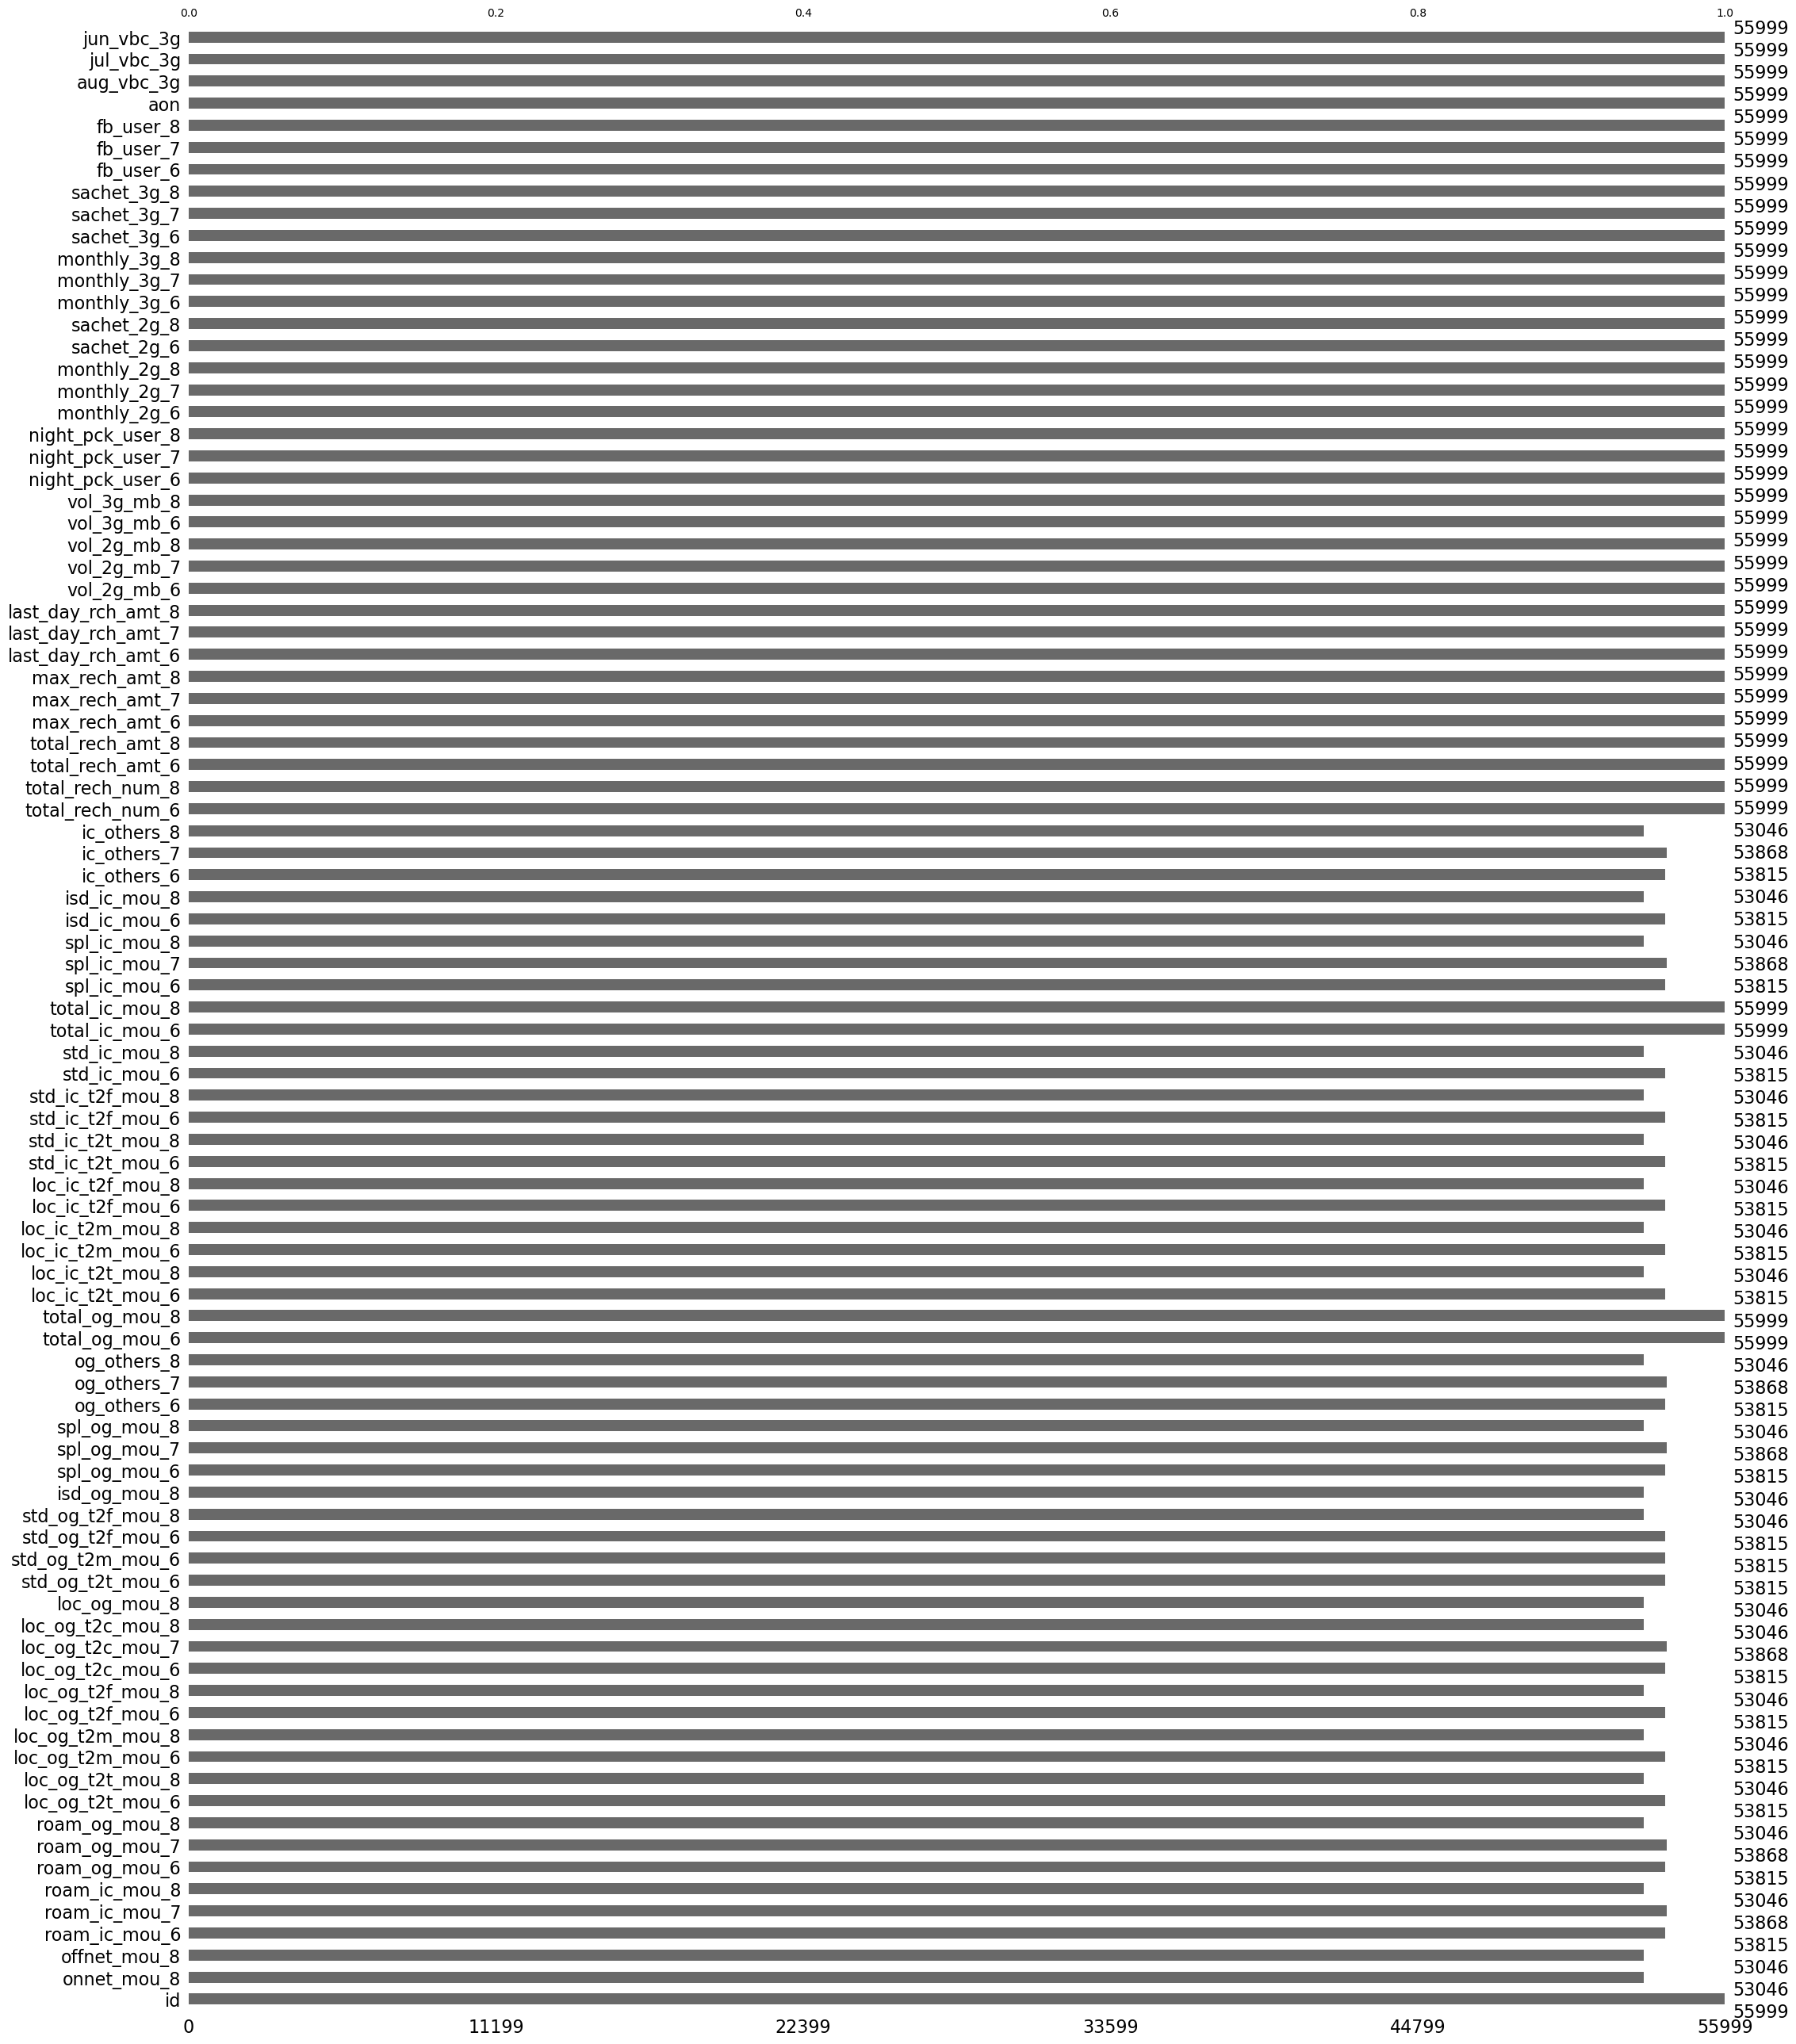

In [117]:
msno.bar(X_train)

<Axes: >

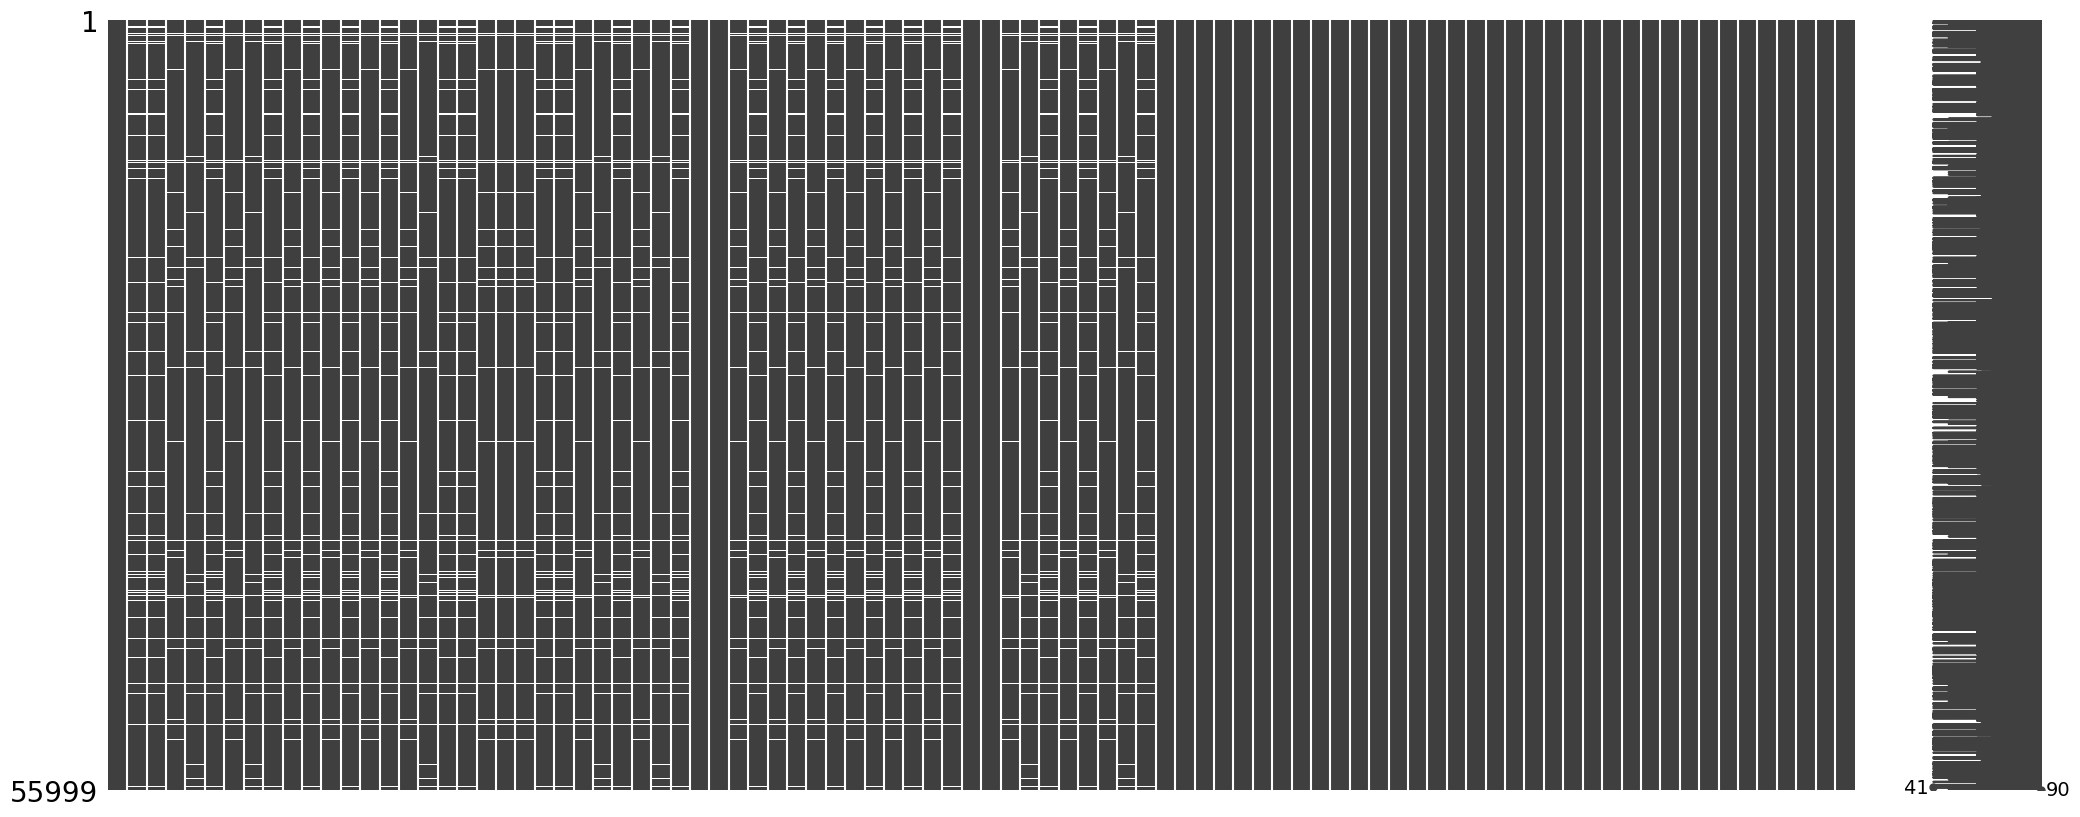

In [118]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [119]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

id               0.000000
onnet_mou_8      5.273308
offnet_mou_8     5.273308
roam_ic_mou_6    3.900070
roam_ic_mou_7    3.805425
                   ...   
fb_user_8        0.000000
aon              0.000000
aug_vbc_3g       0.000000
jul_vbc_3g       0.000000
jun_vbc_3g       0.000000
Length: 90, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [120]:
[missing_data_percent.le(40)]

[id               True
 onnet_mou_8      True
 offnet_mou_8     True
 roam_ic_mou_6    True
 roam_ic_mou_7    True
                  ... 
 fb_user_8        True
 aon              True
 aug_vbc_3g       True
 jul_vbc_3g       True
 jun_vbc_3g       True
 Length: 90, dtype: bool]

In [121]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
print(new_vars)

Index(['id', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'total_og_mou_6', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_8',
       'std_ic_mou_6', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_8',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6',
       'is

In [122]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 90)

In [123]:
X_test_filtered = X_test[new_vars]

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data -

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [124]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_8',
       'std_ic_t2f_mou_6', 'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_8',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6',
       'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8'],
      dtype='object')

In [125]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

In [126]:
X_test_filtered[impute_cols] = imp.transform(X_test[impute_cols])

<Axes: >

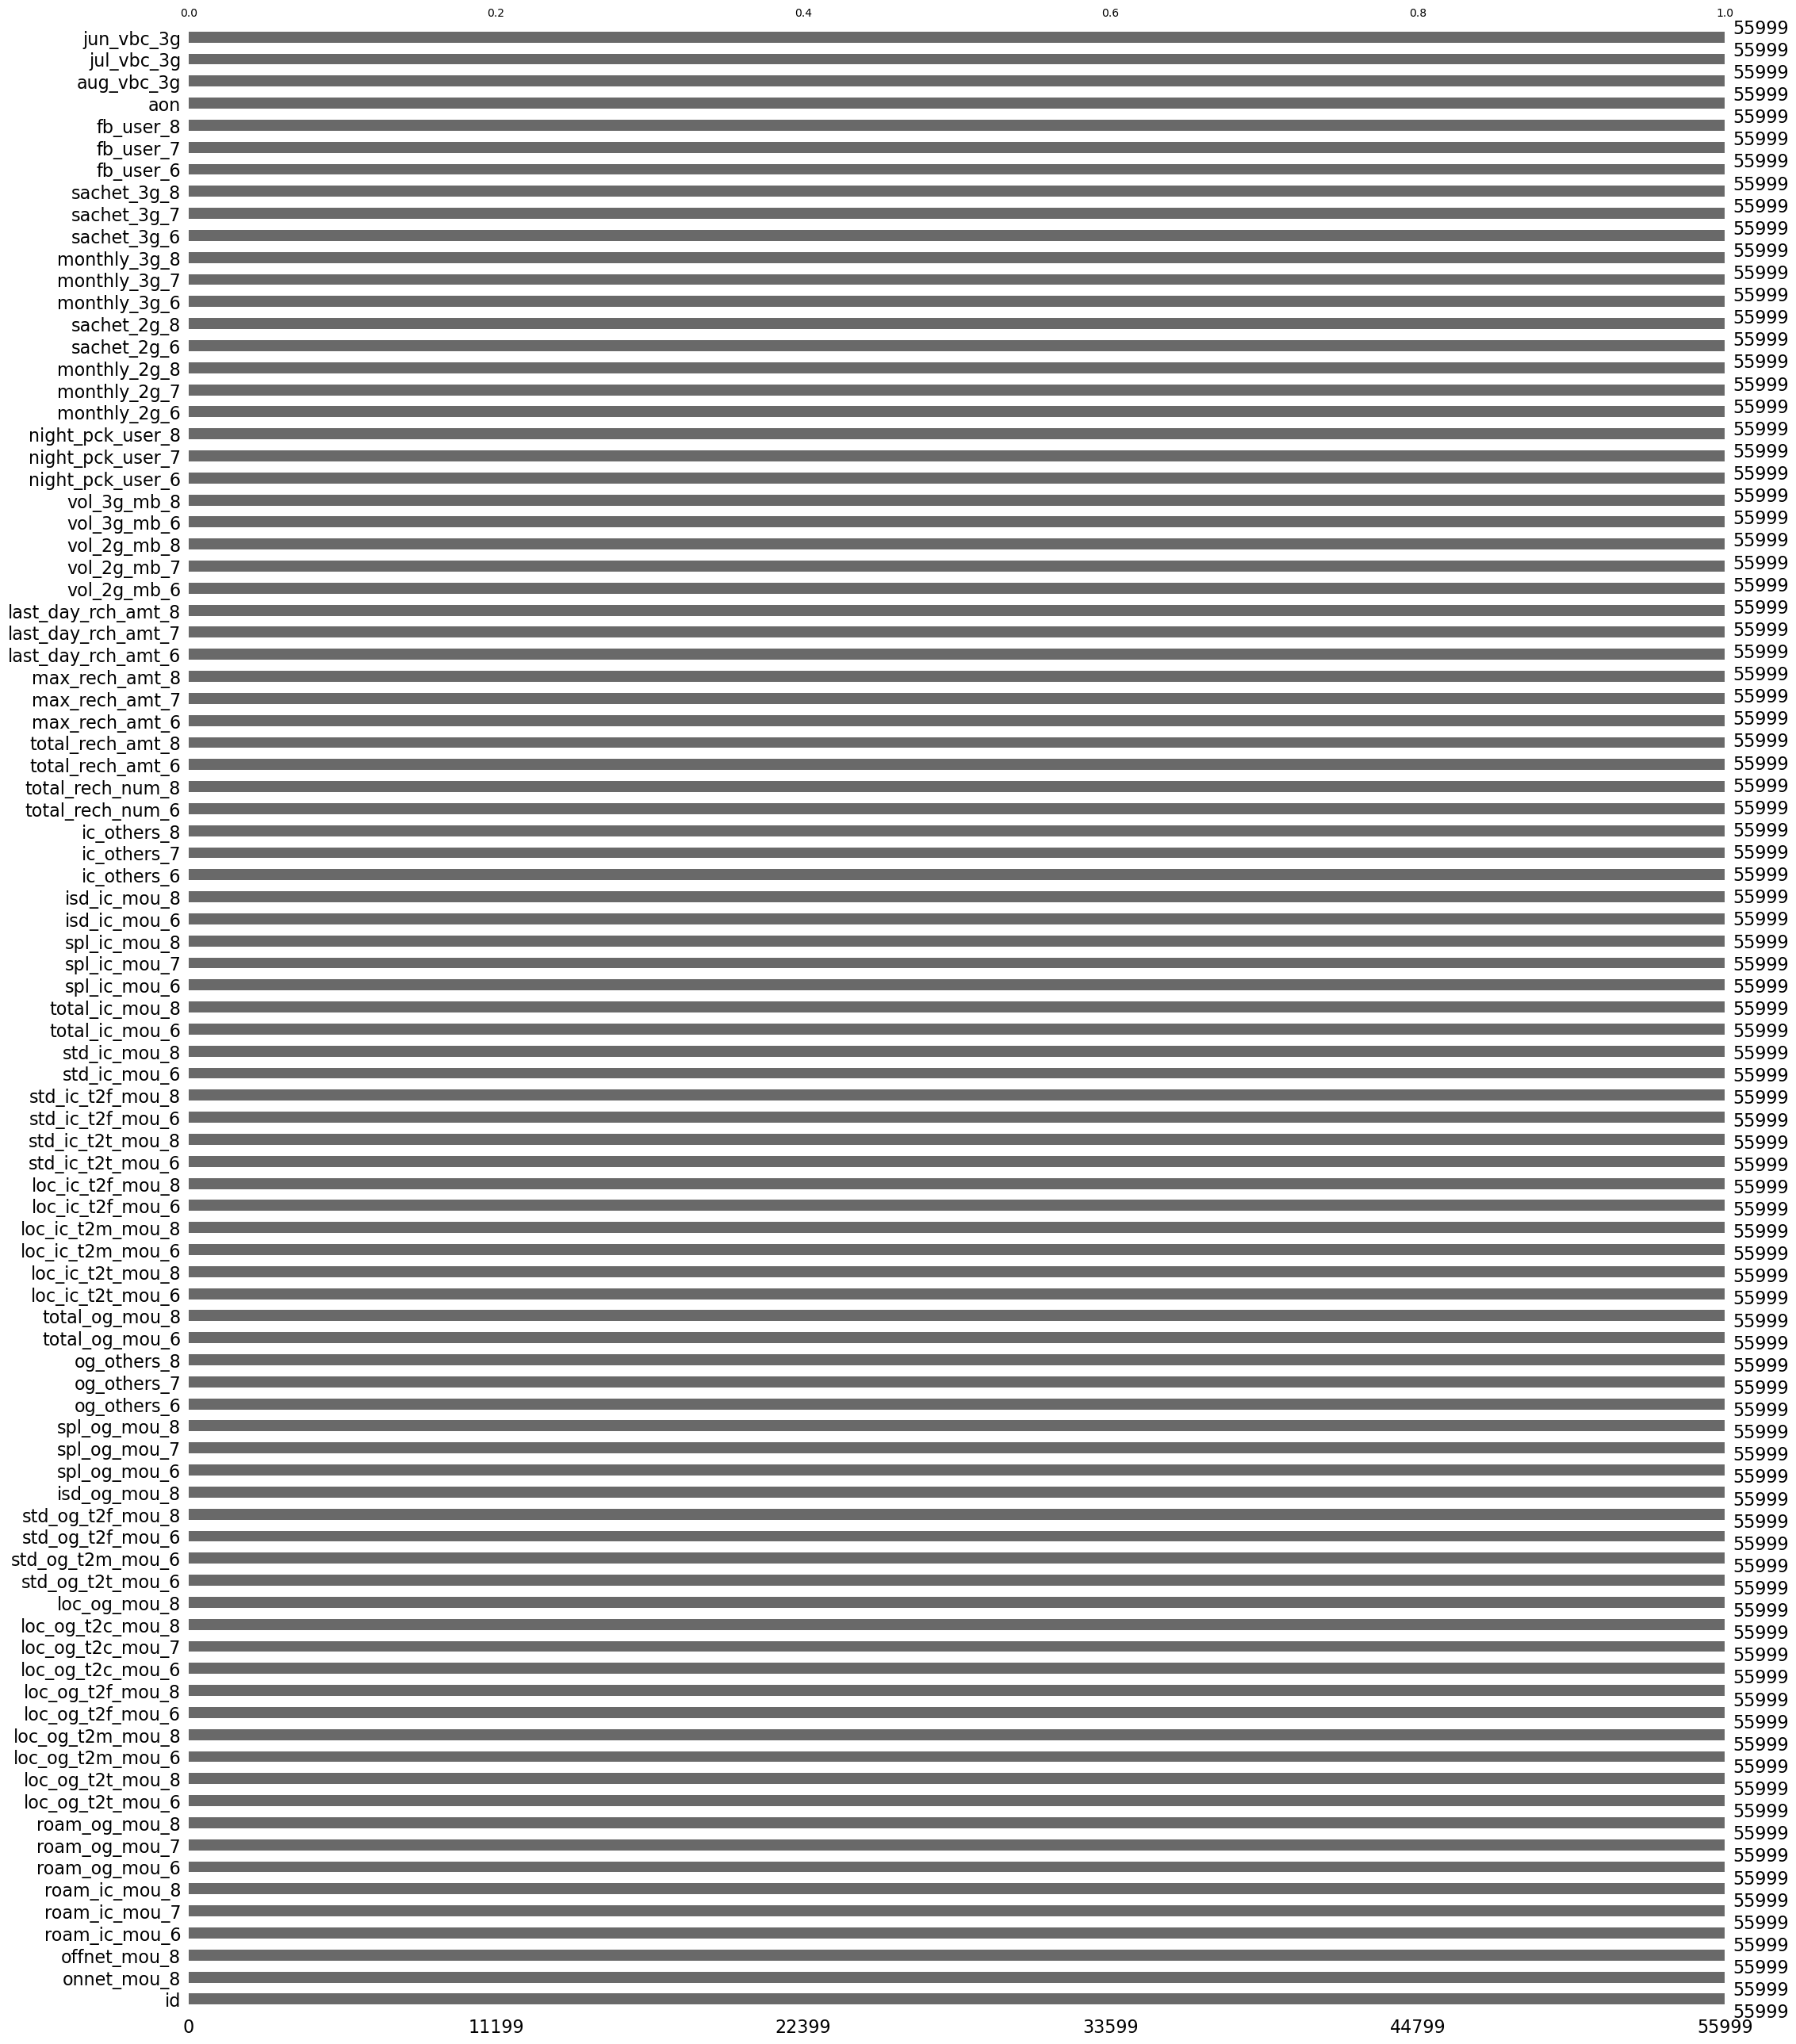

In [127]:
msno.bar(X_train_filtered)

In [128]:
X_train_filtered.describe()

,id,onnet_mou_8,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,...,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.00000,55999.000000,55999.000000,55999.000000
mean,35056.626922,126.020040,186.863527,9.383954,6.808767,6.671770,13.741786,9.508326,9.224669,45.512368,...,0.076287,0.080841,0.086144,0.230879,0.233201,0.234183,1219.34722,68.056341,65.992600,60.251151
std,20214.951672,306.905017,319.584771,55.386668,54.047490,52.352014,72.390014,56.827066,60.508875,150.076257,...,0.565918,0.606921,0.670412,0.421399,0.422873,0.423491,951.75851,269.827282,264.931874,257.293254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.00000,0.000000,0.000000,0.000000
25%,17531.500000,4.090000,23.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,467.00000,0.000000,0.000000,0.000000
50%,35050.000000,27.810000,83.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.740000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.00000,0.000000,0.000000,0.000000
75%,52556.500000,106.280000,216.820000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.740000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1811.00000,0.000000,0.000000,0.000000
max,69997.000000,10752.560000,14007.340000,2613.310000,3813.290000,4169.810000,3775.110000,1900.060000,3493.360000,6431.330000,...,29.000000,24.000000,38.000000,1.000000,1.000000,1.000000,4337.00000,12916.220000,8716.150000,11166.210000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

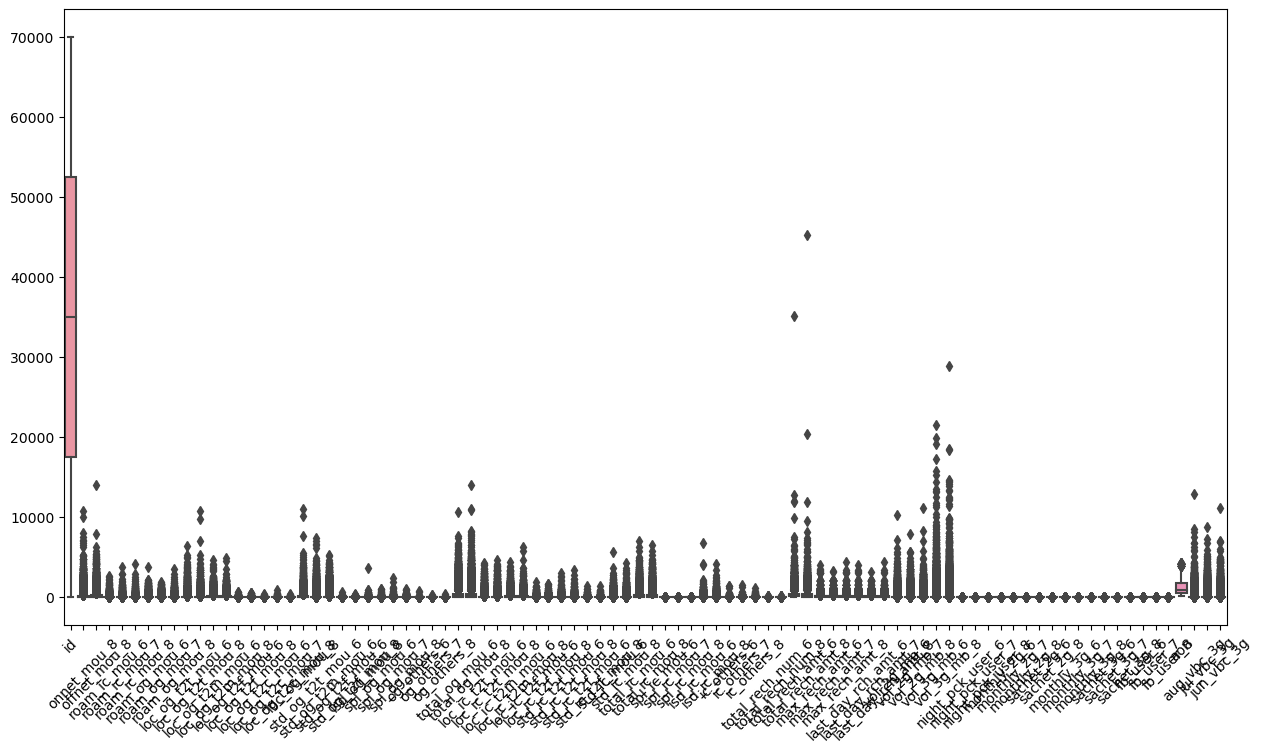

In [129]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [130]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

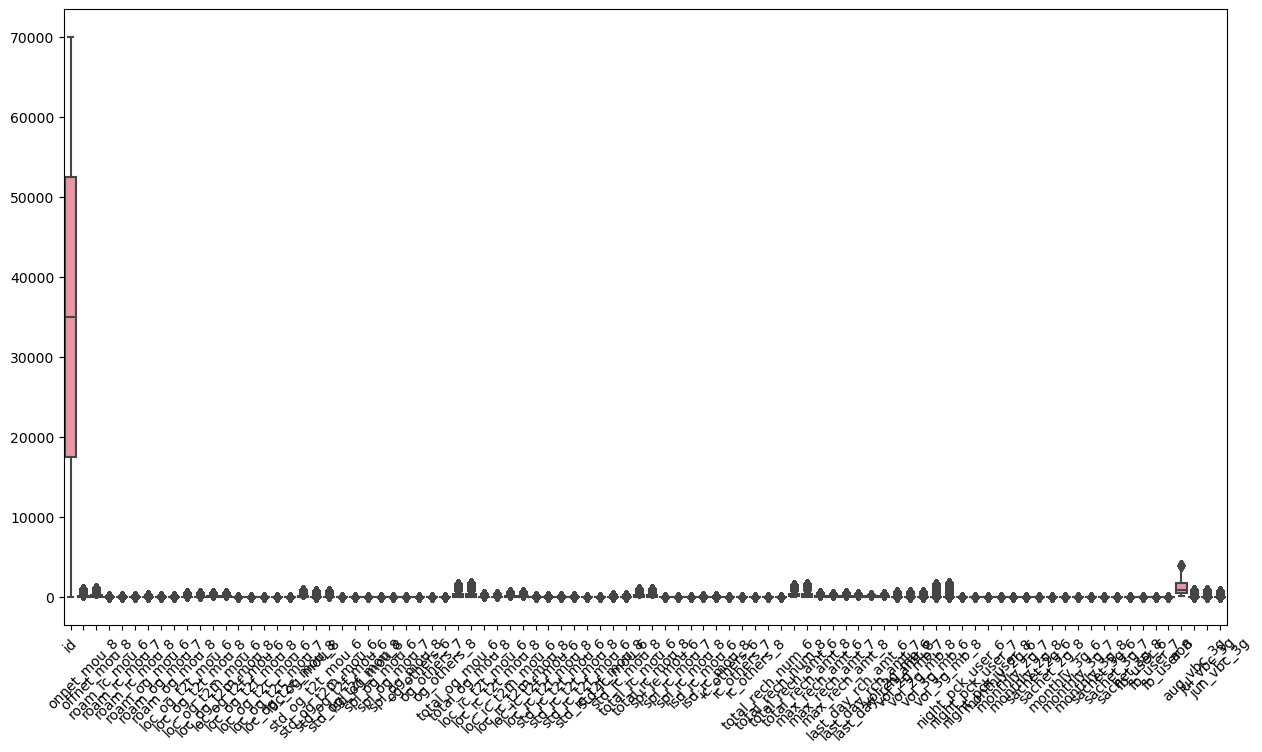

In [131]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [132]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

In [133]:
X_test_filtered2 = scale.transform(X_test_filtered[new_vars])

In [134]:
X_test_filtered2

array([[-1.49858866, -0.13860951, -0.03487701, ...,  0.1115932 ,
         0.39740324, -0.23399218],
       [-0.31608703, -0.53191782, -0.72452525, ..., -0.3197955 ,
        -0.31130066, -0.30177594],
       [ 0.17889755, -0.22281232, -0.70418299, ..., -0.3197955 ,
        -0.31130066, -0.30177594],
       ...,
       [-0.86657557, -0.48056543, -0.66764149, ..., -0.3197955 ,
        -0.31130066, -0.30177594],
       [-0.05266579, -0.53191782, -0.7243181 , ..., -0.3197955 ,
        -0.31130066, -0.30177594],
       [-1.59178784, -0.47976305, -0.49268147, ..., -0.3197955 ,
        -0.31130066, -0.30177594]])

<Axes: >

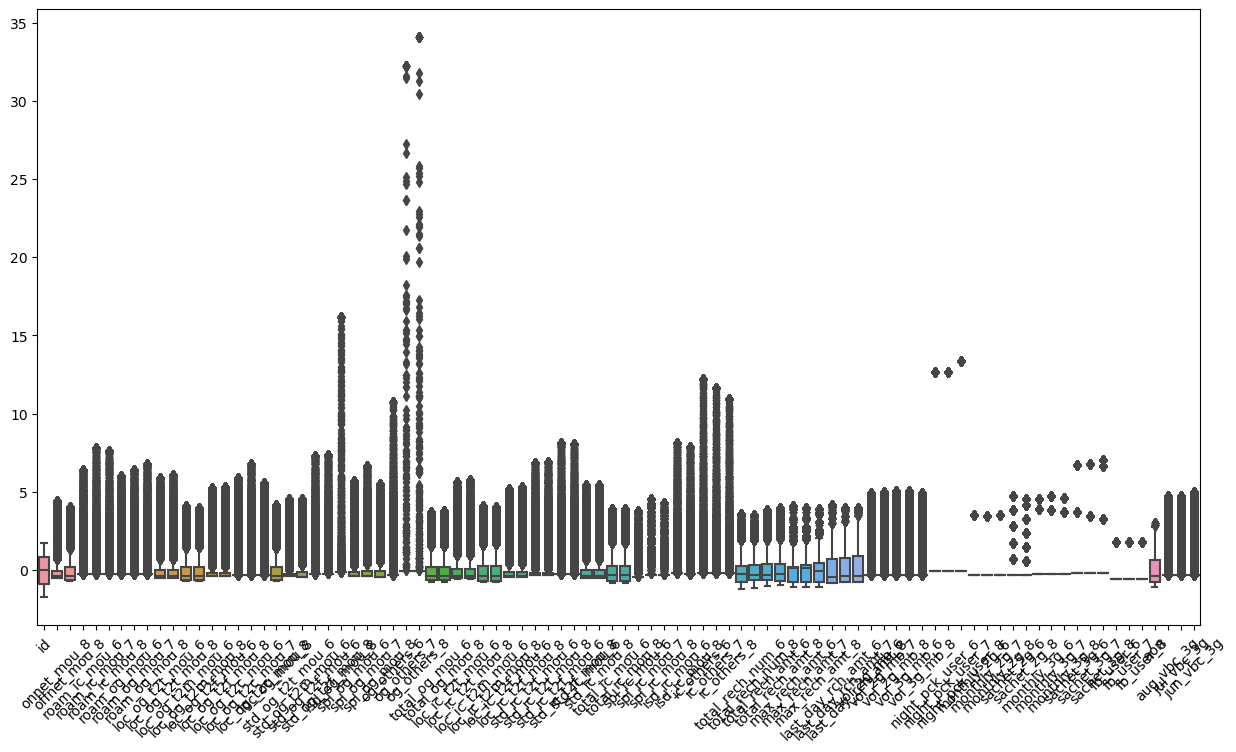

In [135]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage.

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html

Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

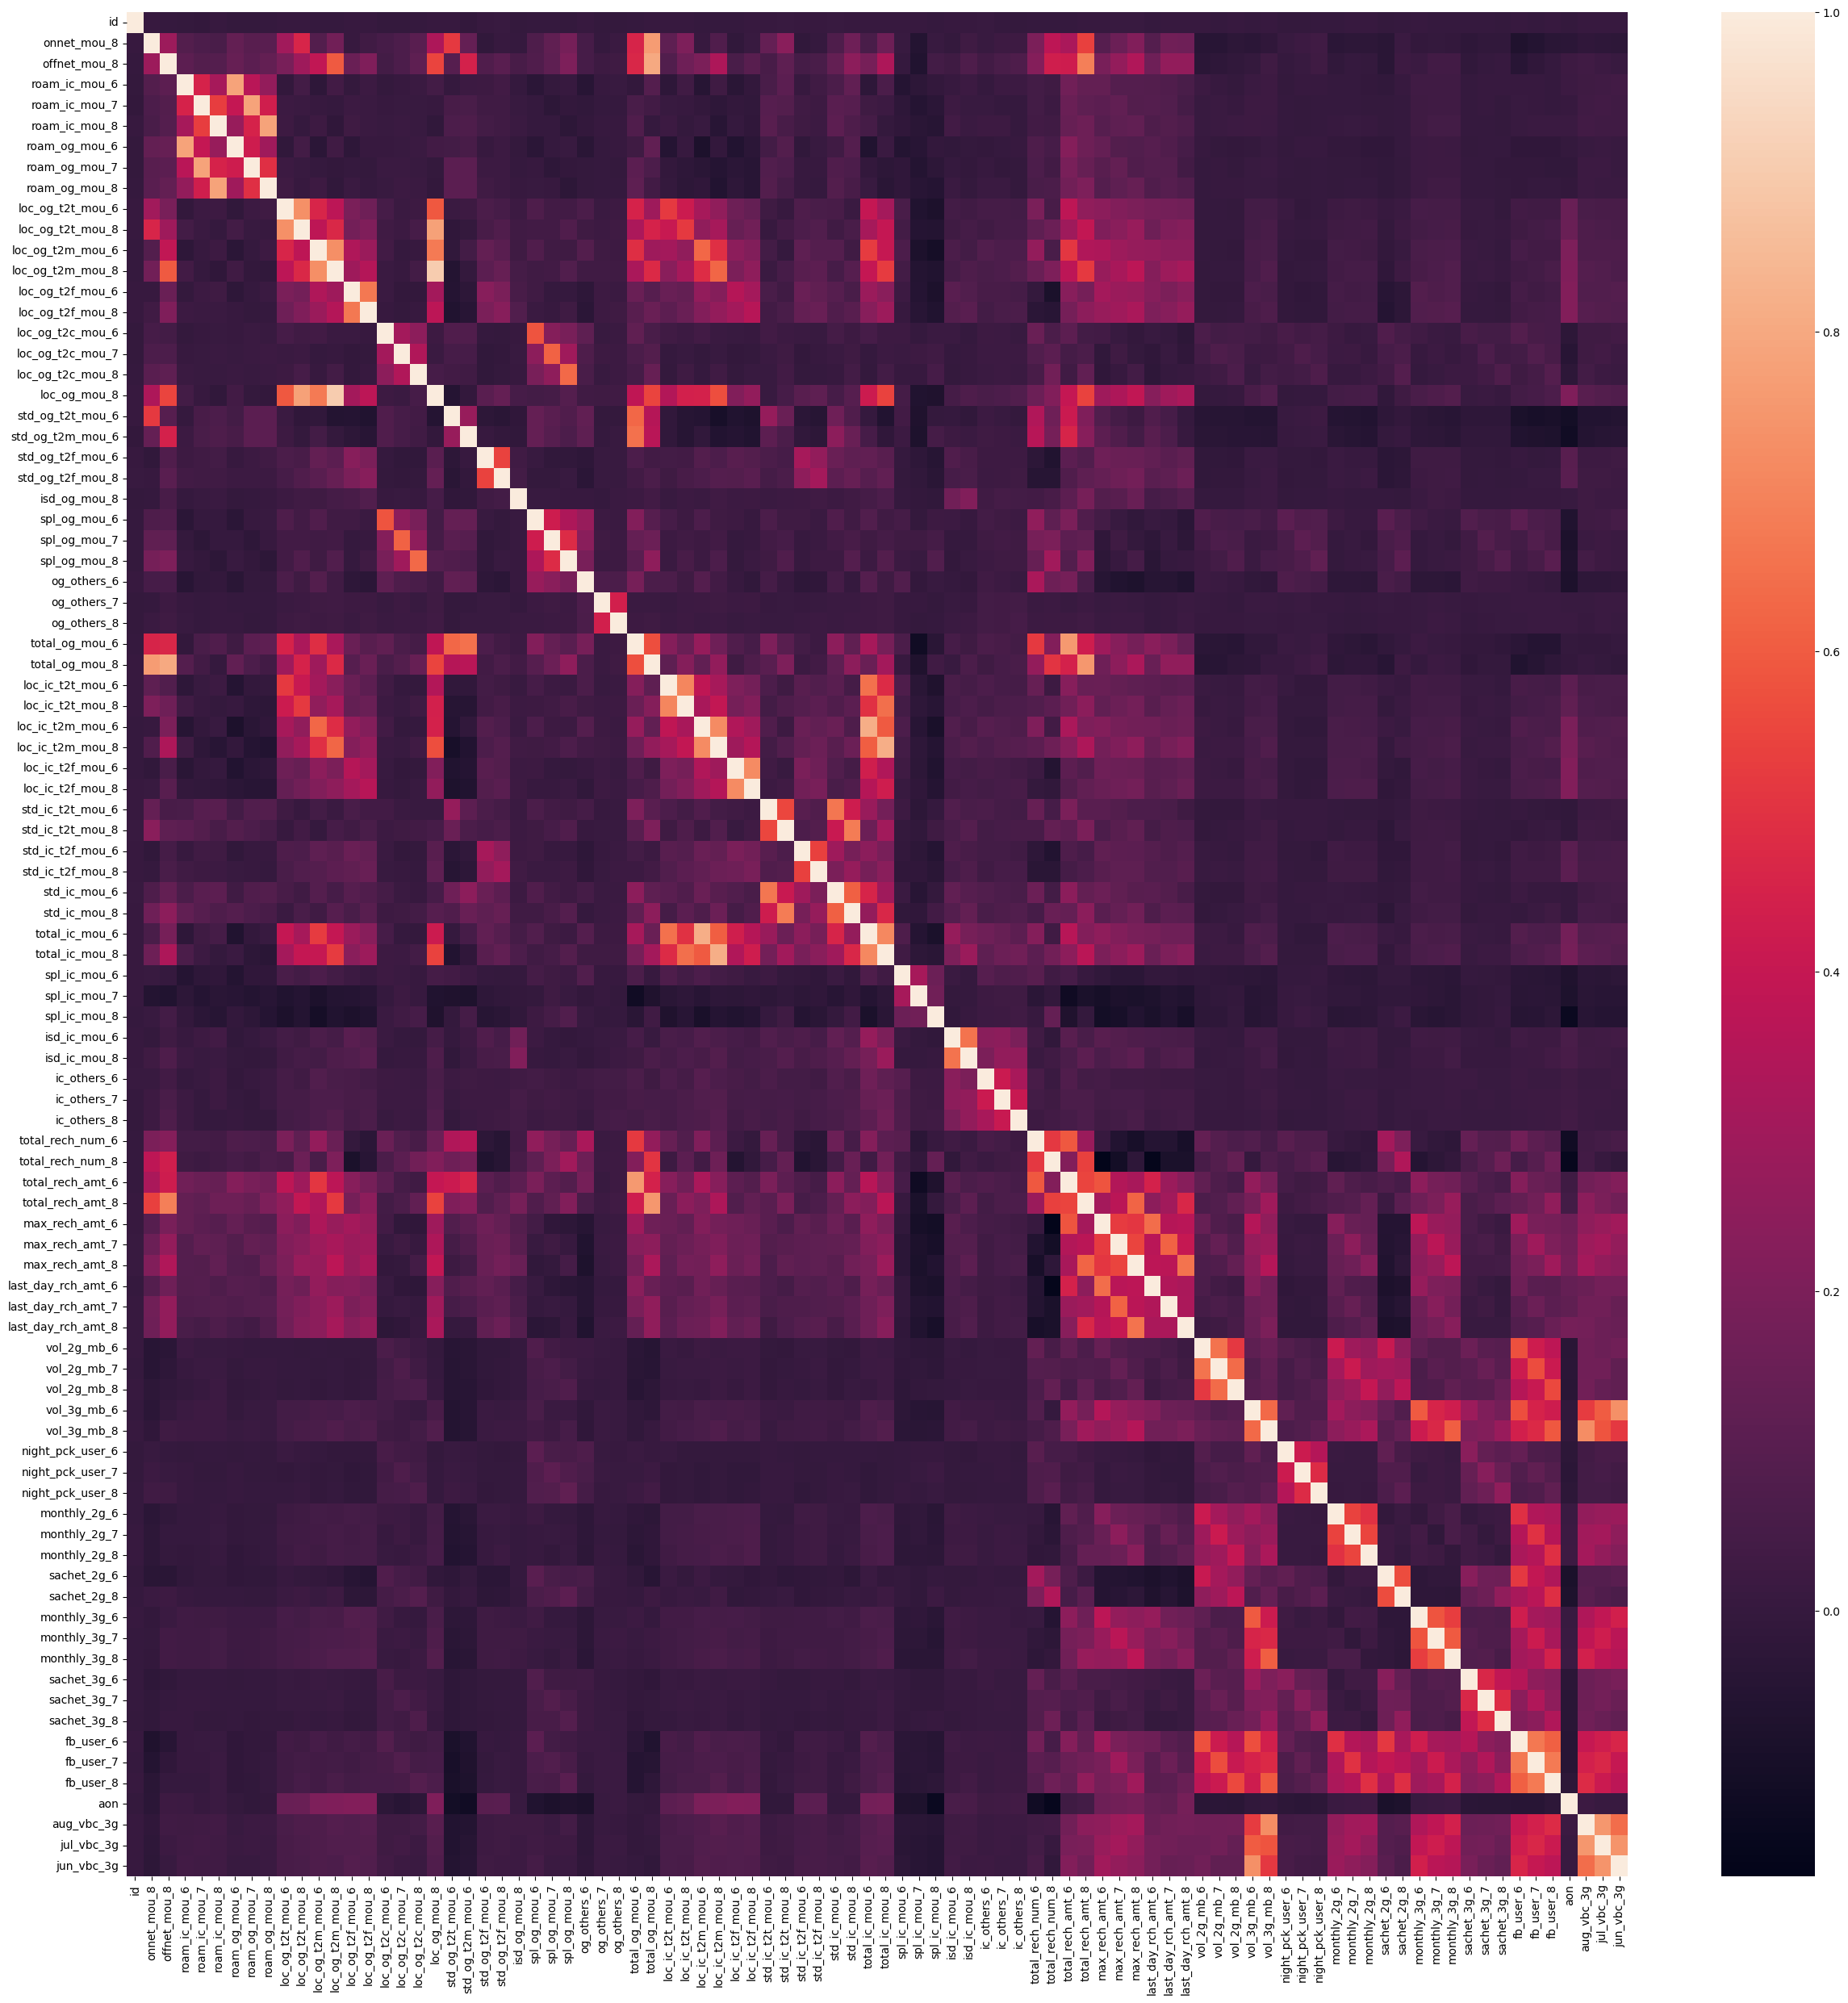

In [136]:
plt.figure(figsize=(30,30))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

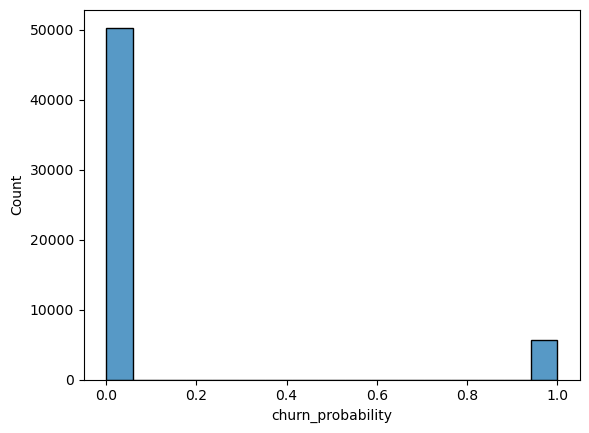

In [137]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and Selection using RFECV and Logistic Regression

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [138]:
X_train_filtered2

array([[-0.58757167, -0.45375646, -0.31950295, ..., -0.3197955 ,
        -0.31130066, -0.30177594],
       [ 0.85810386,  0.61090877,  0.85069495, ..., -0.3197955 ,
        -0.31130066, -0.30177594],
       [-1.44634964, -0.53191782,  0.10412153, ..., -0.3197955 ,
        -0.31130066, -0.30177594],
       ...,
       [ 0.20541282, -0.53191782, -0.72452525, ..., -0.3197955 ,
        -0.31130066, -0.13415026],
       [ 1.38425376, -0.53191782, -0.72452525, ..., -0.3197955 ,
        -0.31130066, -0.11992325],
       [ 0.85310751,  0.5461519 ,  0.16460972, ..., -0.3197955 ,
        -0.07927012,  4.29082632]])

In [139]:
#random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model = LogisticRegression(max_iter=1000)

In [140]:
# Set up the hyperparameter grid
param_grid = {
    'feature_selection__n_features_to_select': [35, 40, 45, 50, 55],  # Number of features to select
    'feature_selection__step': [1, 2],  # Step size for RFE
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': np.logspace(-4, 4, 20),
    'logisticregression__solver': ['liblinear', 'saga']
}

In [141]:
# rfecv = RFECV(estimator=model, n_jobs=-1, step=2, cv=StratifiedKFold(5), scoring='accuracy')
# Set up the RFE and pipeline
rfe = RFE(estimator=model)

In [142]:
pipeline = Pipeline([('feature_selection', rfe), ('logisticregression', model)])

In [143]:
# Set up the grid search with cross-validation
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)


In [144]:
# Fit the grid search to the data
grid_search.fit(X_train_filtered2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('feature_selection',
                                        RFE(estimator=LogisticRegression(max_iter=1000))),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'feature_selection__n_features_to_select': [35, 40, 45,
                                                                     50, 55],
                         'feature_selection__step': [1, 2],
                         'logi...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [145]:
# Get the best model
best_model = grid_search.best_estimator_

In [146]:
# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'feature_selection__n_features_to_select': 55, 'feature_selection__step': 2, 'logisticregression__C': 4.281332398719396, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best Score: 0.9189806599441276


In [180]:
#rf.fit(X_train_filtered2, y_train)

KeyboardInterrupt: 

In [ ]:
# Get the number of features selected by RFECV based on best cross-validated performance
optimal_features_rfecv = rf.n_features_

# Get the indices of the selected features
rfecv_support = rf.support_

# Get the names of the selected features (assuming you have feature names)
selected_features_rfecv = X_train.columns[rfecv_support]

print(f"RFECV Selected Features ({optimal_features_rfecv} features): {selected_features_rfecv}")

In [ ]:
print(new_vars)

In [ ]:
print(len(new_vars), len(selected_features_rfecv))

We have new shortlisted to only 53 features that can explain the vairance in all the feature variables.

#### Analysis on RFECV results

In [ ]:
# X_train_fitlered2 is scaled. Since its anumpy array, lets create dataframe
X_train_scaled = pd.DataFrame(X_train_filtered2, columns=new_vars)

In [ ]:
X_test_scaled = pd.DataFrame(X_test_filtered2, columns=new_vars)

In [ ]:
X_train_scaled.head()


In [ ]:
def build_logistic_model(XTrain, ytrain, XTest, ytest, add_constant=True, family=sm.families.Binomial()):
    try:
        # Ensure X is a DataFrame for consistent handling
        if not isinstance(XTrain, pd.DataFrame):
            X = pd.DataFrame(XTrain)

        # Optionally add a constant to the feature matrix
        if add_constant:
            XTrain = sm.add_constant(XTrain)
            XTest = sm.add_constant(XTest)

        # Build and fit the logistic regression model
        logm2 = sm.GLM(ytrain, XTrain, family=family)
        res = logm2.fit()

        # Output the summary of the model
        print(res.summary())

                # Predict on the test set
        y_pred = res.predict(XTest)
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Calculate and print evaluation metrics
        auc = roc_auc_score(y_test, y_pred)
        precision = precision_score(ytest, y_pred_binary)
        recall = recall_score(ytest, y_pred_binary)
        f1 = f1_score(ytest, y_pred_binary)

        print(f'AUC-ROC: {auc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

        return res

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def print_vif(X):
    vif = pd.DataFrame(data=X.columns, columns=['Features'])
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [ ]:
build_logistic_model(X_train_scaled[selected_features_rfecv], y_train.values, X_test_scaled[selected_features_rfecv], y_test.values)

While accuracy is quite good at 0.89, the precision with which we need to find a customer churns or not is not quite great. We need to improve the Precision. Lets analyse the P-Values and VIF :

In [ ]:
print_vif(X_train_scaled[selected_features_rfecv])

Analysing the above model predictions summary, we need to improve the model fitment.
Pseudo R-squ. (CS): The Cragg & Uhler's (also known as Nagelkerke's) pseudo R-squared. This is an indicator of model fit, similar to the R-squared in linear regression. Here, it is 0.2093, indicating that approximately only 21% of the variability in the dependent variable is explained by the model.

<pre>
Feature              P-values > 0.05    VIF > 5
---------------------------------------------------------------

loc_ic_t2m_mou_6       0.382             5.55

last_day_rch_amt_7     0.144

total_og_mou_6         0.137             9.30

jun_vbc_3g             0.129

og_others_8            0.117

loc_og_t2f_mou_8       0.113

ic_others_8            0.081

max_rech_amt_6         0.059

Lets remove loc_ic_t2m_mou_6 and loc_ic_t2m_mou_6 and analyse the resutls again

## Model 2

In [ ]:
X_train_scaled = X_train_scaled[selected_features_rfecv]
X_test_scaled = X_test_scaled[selected_features_rfecv]
X_train_scaled.drop(columns=['loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_6'], inplace=True)
X_test_scaled.drop(columns=['loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_6'], inplace=True)
build_logistic_model(X_train_scaled, y_train.values.reshape(-1,1), X_test_scaled, y_test.values.reshape(-1,1))
print_vif(X_train_scaled[selected_features_rfecv])

In [144]:
#feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.selected_features_rfecv})

AttributeError: 'RFECV' object has no attribute 'selected_features_rfecv'

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<Axes: >

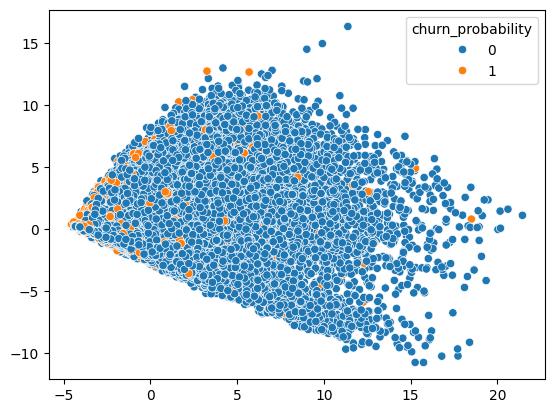

In [145]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

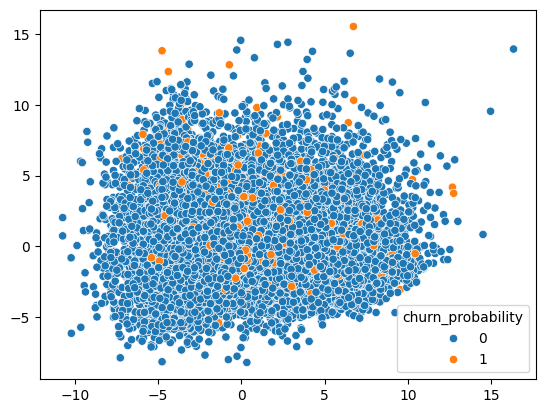

In [146]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [147]:
# Fit the first model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

KeyboardInterrupt: 

In [ ]:
# Get the number of components from the pca object
num_components = pca_components.shape[1]

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(num_components)],
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

In [ ]:
lr.score(pca_components[:,:2], y_train)

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [169]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=50)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [170]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [171]:
pipe.fit(X_train[selected_features_rfecv], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=50)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [172]:
train_score = pipe.score(X_train[selected_features_rfecv], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9125162949338381


In [173]:
test_score = pipe.score(X_test[selected_features_rfecv], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9131428571428571


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [174]:
confusion_matrix(y_train, pipe.predict(X_train[selected_features_rfecv]))

array([[49692,   615],
       [ 4284,  1408]])

In [175]:
confusion_matrix(y_test, pipe.predict(X_test[selected_features_rfecv]))

array([[12405,   155],
       [ 1061,   379]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [176]:
precision_score(y_test, pipe.predict(X_test[selected_features_rfecv]))

0.7097378277153558

In [177]:
recall_score(y_test, pipe.predict(X_test[selected_features_rfecv]))

0.26319444444444445

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [178]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [179]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84,0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00,0


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [180]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84,0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00,0


In [181]:
submission_data = unseen[selected_features_rfecv]
submission_data.shape

(30000, 63)

In [182]:
# submission_data = unseen.set_index('id')[new_vars]
# submission_data.shape

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [183]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [185]:
output.to_csv('/content/drive/MyDrive/Colab Notebooks/01. Assignments/2. Telecom Churn Case Study/Kaggle Submission Files/submission_pca_lr_05_June_2024_22_45_hrs.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.